In [49]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("sales_data_v2/file6.csv")

In [3]:
df["Sale Date"] = pd.to_datetime(df["Sale Date"])
df["week"] = df["Sale Date"].dt.week
df["year"] = df["Sale Date"].dt.year
df["month"] = df["Sale Date"].dt.month
df["Amount"] = df["Sales Price"] * df["Sales Qty"]

In [4]:
def preprocess_data(df):
    # Keep rows where price > 0 
    df = df[df["Sales Price"] > 0]

    # Keep rows where MRP >= sell price
    df = df[df["MRP"] >= df["Sales Price"]]
    
    print('Number of missing values:\n',df.isnull().sum())
    df = df[~df["Category"].isnull()]
    
    # Remove returned items
    df = df[df["Sales Qty"]>0]

    df["Sale Date"] = pd.to_datetime(df["Sale Date"])
    return df

df = preprocess_data(df)

Number of missing values:
 SKU Code       0
Brand Code     0
Category       0
Bill Number    0
Store Code     0
Sale Date      0
Sale/Return    0
MRP            0
Sales Price    0
Sales Qty      0
week           0
year           0
month          0
Amount         0
dtype: int64


In [5]:
df.head()

,SKU Code,Brand Code,Category,Bill Number,Store Code,Sale Date,Sale/Return,MRP,Sales Price,Sales Qty,week,year,month,Amount
0,SKU0729,BRAND017,Cat07,BILL02591,Store 5,2017-09-16,Sale,25.33,25.33,1,37,2017,9,25.33
1,SKU0624,BRAND027,Cat04,BILL02592,Store 5,2017-09-16,Sale,2.00,2.00,1,37,2017,9,2.00
2,SKU0650,BRAND027,Cat04,BILL02592,Store 5,2017-09-16,Sale,1.33,1.33,1,37,2017,9,1.33
3,SKU0730,BRAND018,Cat04,BILL02593,Store 5,2017-09-16,Sale,24.67,24.67,1,37,2017,9,24.67
4,SKU0731,BRAND018,Cat04,BILL02593,Store 5,2017-09-16,Sale,20.67,20.67,1,37,2017,9,20.67


In [6]:
df["discount"] = df.apply(lambda x: 100*(1 - x["Sales Price"]/x["MRP"]), axis=1)

In [7]:
def get_features_by_category(df):
    cat_feaures = pd.Series()
    cat_feaures["SKUs"] = len(df["SKU Code"].unique())
    cat_feaures["Brands"] = len(df["Brand Code"].unique())
    cat_feaures["Cat avg selling price"] = sum(df["Amount"])/sum(df["Sales Qty"])
    return cat_feaures

In [8]:
grouped_df = df.groupby("Category").apply(get_features_by_category)
grouped_df = grouped_df.reset_index()
grouped_df

,Category,SKUs,Brands,Cat avg selling price
0,Cat01,522.0,28.0,64.215815
1,Cat02,103.0,6.0,17.506802
2,Cat03,58.0,4.0,24.682842
3,Cat04,299.0,9.0,6.654645
4,Cat07,1002.0,14.0,19.828045
5,Cat08,43.0,4.0,8.145342


In [9]:
df = df.merge(grouped_df, on="Category", how="left")

In [10]:
df.keys()

Index(['SKU Code', 'Brand Code', 'Category', 'Bill Number', 'Store Code',
       'Sale Date', 'Sale/Return', 'MRP', 'Sales Price', 'Sales Qty', 'week',
       'year', 'month', 'Amount', 'discount', 'SKUs', 'Brands',
       'Cat avg selling price'],
      dtype='object')

In [11]:
df.head()

,SKU Code,Brand Code,Category,Bill Number,Store Code,Sale Date,Sale/Return,MRP,Sales Price,Sales Qty,week,year,month,Amount,discount,SKUs,Brands,Cat avg selling price
0,SKU0729,BRAND017,Cat07,BILL02591,Store 5,2017-09-16,Sale,25.33,25.33,1,37,2017,9,25.33,0.0,1002.0,14.0,19.828045
1,SKU0624,BRAND027,Cat04,BILL02592,Store 5,2017-09-16,Sale,2.00,2.00,1,37,2017,9,2.00,0.0,299.0,9.0,6.654645
2,SKU0650,BRAND027,Cat04,BILL02592,Store 5,2017-09-16,Sale,1.33,1.33,1,37,2017,9,1.33,0.0,299.0,9.0,6.654645
3,SKU0730,BRAND018,Cat04,BILL02593,Store 5,2017-09-16,Sale,24.67,24.67,1,37,2017,9,24.67,0.0,299.0,9.0,6.654645
4,SKU0731,BRAND018,Cat04,BILL02593,Store 5,2017-09-16,Sale,20.67,20.67,1,37,2017,9,20.67,0.0,299.0,9.0,6.654645


In [13]:
def get_previous_year_week(year, week):
    week_start_date = datetime.strptime("%d-%d"%(year, week) + '-1', "%Y-%W-%w")
    dt = week_start_date - timedelta(days=7)
    year = dt.year
    week = dt.isocalendar()[1]
    return (year, week)


def get_next_year_week(year, week):
    week_start_date = datetime.strptime("%d-%d"%(year, week) + '-1', "%Y-%W-%w")
    dt = week_start_date + timedelta(days=7)
    year = dt.year
    week = dt.isocalendar()[1]
    return (year, week)

def get_month_from_year_week(year, week):
    return datetime.strptime("%d-%d"%(year, week) + '-1', "%Y-%W-%w").month

def get_season(month):
    return str(int((month + 1)%12 / 3))

def get_last_week_sale(df):
    df["year_week"] = df.apply(lambda x: (x["year"], x["week"]), axis=1)
    temp_df = df.copy()
    temp_df = temp_df[["year_week", "weekly_SUs_sold"]]
    temp_df.columns = ["y_w", "previous_week_sale"]
    df["previous_year_week"] = df.apply(lambda x: get_previous_year_week(x["year"], x["week"]), axis=1)
    df = df.merge(temp_df, left_on="previous_year_week", right_on="y_w", how="left")
    return df[["Category", "year", "week", "weekly_SUs_sold", "weekly_discount", "season", "month", "previous_week_sale"]]

In [50]:
def nonzero_mode(arr):
    return stats.mode(arr[np.nonzero(arr)]).mode

def get_discount(df):
    arr = nonzero_mode(np.array(df["discount"]))
    if len(arr) > 0:
        return arr[0]
    return 0

In [51]:
def weekly_features(df):
    series = pd.Series()
    series["weekly_SUs_sold"] = sum(df["Sales Qty"])
    series["weekly_discount"] = get_discount(df)  # 100 * (1 - np.sum(df["Amount"])/np.sum(df["MRP"]*df["Sales Qty"]))
    series["season"] = get_season(df["month"].head(1))
    series["month"] = df["month"].max()
    return series

def more_features(df):
    df = get_last_week_sale(df)
    return df[["year","week", "weekly_SUs_sold", "weekly_discount", "season", "month", "previous_week_sale"]]

In [52]:
temp_df = df.groupby(["Category", "year", "week"]).apply(weekly_features).reset_index()
temp_df = temp_df.groupby("Category").apply(more_features).reset_index().fillna(0)

D:\Anaconda\envs\py36\lib\site-packages\pandas\core\groupby\groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


In [53]:
le = LabelEncoder()
temp_df["Category"] = le.fit_transform(temp_df["Category"])

In [54]:
t_df = temp_df[["Category", "year", "week", "month", "season"]].astype("category")
t_df["weekly_discount"] = temp_df["weekly_discount"]
t_df["qty sold"] = temp_df["weekly_SUs_sold"]
t_df["previous_week_sale"] = temp_df["previous_week_sale"]

In [55]:
features = ['Category', 'year', 'week', 'month', 'season']

In [56]:
X = np.array(t_df[features].values)
y = np.array(t_df["qty sold"])

In [57]:
X.shape, y.shape

((283, 5), (283,))

In [58]:
def train_regressor(regressor, X, y):
    regressor.fit(X, y)
    print(regressor.feature_importances_)
    print(regressor.score(X,y))
    return regressor

In [59]:
rf = RandomForestRegressor(n_estimators=50, max_depth=2)
xgb = XGBRegressor( learning_rate=1, n_estimators=50)

In [60]:
rf = train_regressor(rf, X, y)

[9.80160838e-01 1.93156233e-06 1.06867409e-02 9.15048972e-03
 0.00000000e+00]
0.4635449307920916


In [61]:
xgb = train_regressor(xgb, X, y)

[0.37463978 0.06051873 0.4755043  0.06628242 0.02305475]
0.9610054527204551


In [62]:
y_pred = xgb.predict(X)

In [63]:
t_df["pred"] = list(map(lambda x: max(x,0), y_pred))

In [64]:
categories = df["Category"].unique().tolist()
categories.sort()
categories

['Cat01', 'Cat02', 'Cat03', 'Cat04', 'Cat07', 'Cat08']

In [65]:
t_df.head()

,Category,year,week,month,season,weekly_discount,qty sold,previous_week_sale,pred
0,0,2017,1,1,0,0.000000,31,0.0,37.408577
1,0,2017,2,1,0,7.894217,55,31.0,51.755486
2,0,2017,3,1,0,0.000000,71,55.0,58.666893
3,0,2017,4,1,0,0.000000,48,71.0,40.554668
4,0,2017,5,2,0,0.000000,36,48.0,28.276741


In [66]:
t_df["residue"] = t_df["qty sold"] - t_df["pred"]

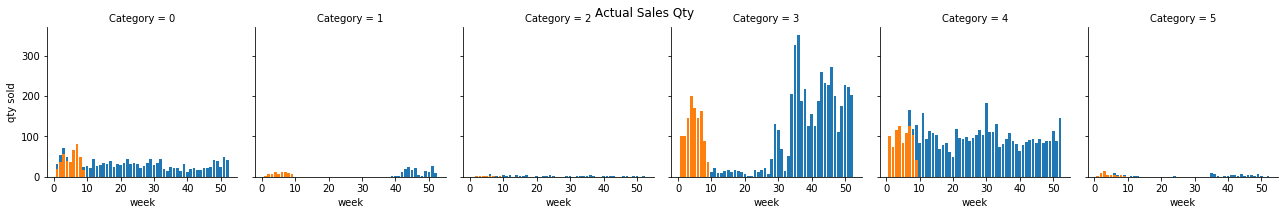

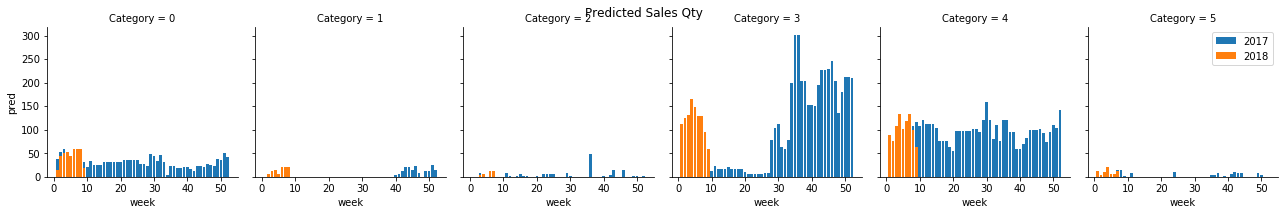

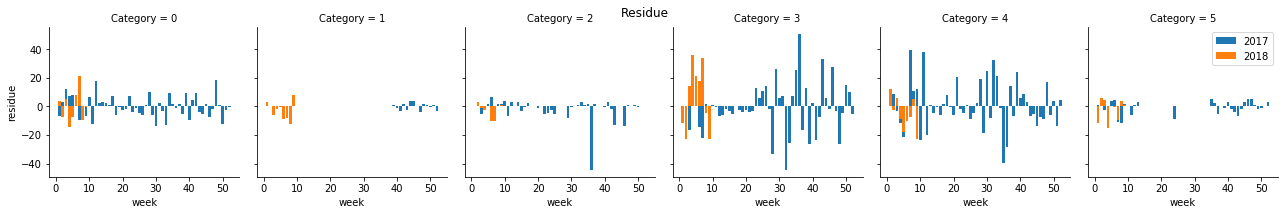

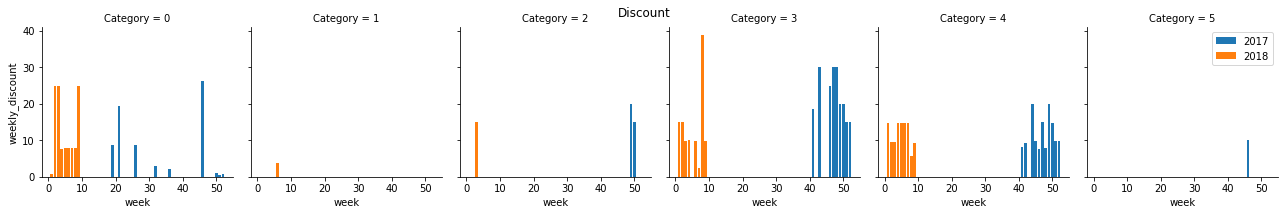

In [67]:
g = sns.FacetGrid(t_df, col="Category", hue="year", margin_titles=True)
g.map(plt.bar, "week", "qty sold")
g.fig.suptitle("Actual Sales Qty")

g = sns.FacetGrid(t_df, col="Category", hue="year", margin_titles=True)
g.map(plt.bar, "week", "pred")
g.fig.suptitle("Predicted Sales Qty")
plt.legend()

g = sns.FacetGrid(t_df, col="Category", hue="year", margin_titles=True)
g.map(plt.bar, "week", "residue")
g.fig.suptitle("Residue")
plt.legend()


g = sns.FacetGrid(t_df, col="Category", hue="year", margin_titles=True)
g.map(plt.bar, "week", "weekly_discount")
g.fig.suptitle("Discount")
plt.legend()

##### NOTE: Residues can't be explained by discount

In [39]:
forecast_df = t_df[t_df["year"]==2017]
forecast_df["year"] = 2018
forecast_df = forecast_df.append(t_df[t_df["year"]==2018])
forecast_df = forecast_df[features]
print(forecast_df.shape)
forecast_df.drop_duplicates()
forecast_df.shape

(283, 5)


D:\Anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(283, 5)

In [40]:
forecast_df["pred"] = xgb.predict(np.array(forecast_df.values))
forecast_df["pred"] = forecast_df["pred"].apply(lambda x: max(0,x))

#### Next year Forecast

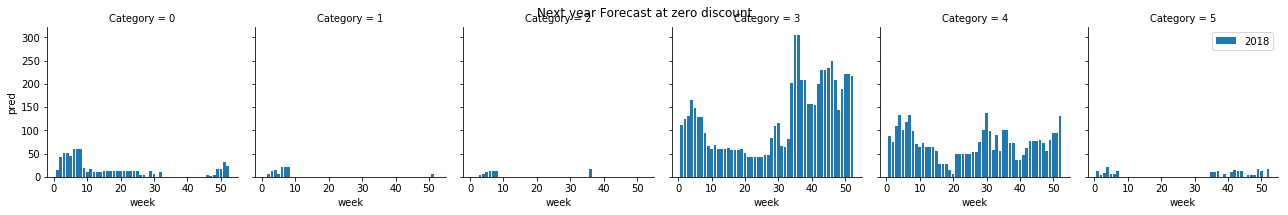

In [42]:
g = sns.FacetGrid(forecast_df, col="Category", hue="year", margin_titles=True)
g.map(plt.bar, "week", "pred")
g.fig.suptitle("Next year Forecast at zero discount")
plt.legend()